In [44]:
import os, sys, torch, dgl
import numpy as np
import pandas as pd
from util import check_files
from data_ import *
from train import *
from torch_geometric.data import Data

from turtle import forward
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
import dgl.nn.pytorch as dglnn
# from dgl.nn import Set2Set

from torch_geometric.nn import SAGEConv, SAGPooling, Set2Set, GraphNorm, global_sort_pool, GlobalAttention
from torch_geometric.utils import add_self_loops, subgraph
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data

In [322]:
omics_files=["./data/LGG/rna.csv.gz", "./data/LGG/met.csv.gz", "./data/LGG/miRNA_gene_mean.csv.gz"]
label_file = "./data/LGG/label.csv"
add_file = None
G, pathway, id_mapping = read_omics(omics_files=omics_files, 
                                    label_file=label_file, 
                                    add_file=add_file, 
                                    pathway_file='./Pathway/Rectome.pathway.tmp.csv')

In [223]:
labels = G.label

In [76]:
class PathFeature(nn.Module):
    def __init__(self, in_dim):
        super(PathFeature, self).__init__()
        # GNN-1
        self.conv1 = SAGEConv(in_dim, in_dim)
        self.pool1 = SAGPooling(in_dim, ratio=0.8)
        self.readout1 = GlobalAttention(gate_nn=nn.Linear(in_dim, 1))
        
    def forward(self, g, h):
        edge_index = g.edge_index
        x = h
        # GNN-1
        x = torch.tanh(self.conv1(x, edge_index))
        x, edge_index, _, _, _, _ = self.pool1(x, edge_index, None, None)
        x = self.readout1(x)

        return x

In [85]:
class DeepMOI(nn.Module):
    def __init__(self, in_dim, pathway, add_features=None):
        """
        in_dim: == omics' number
        hidden_dim: == 
        """
        super(DeepMOI, self).__init__()
        self.pathway = pathway
        
        # Gene Layer
        self.conv = SAGEConv(in_dim, in_dim, 'pool')
                
        # Pathway Layers     
        self.submodels = nn.ModuleList()
        for _ in range(len(self.pathway.pathway.unique())):
            self.submodels.append(PathFeature(in_dim=in_dim))
    
        # MLP
        self.lin = nn.Linear(3, 1)
        self.mlp = nn.Sequential(
                                 nn.Dropout(p=0.2),
                                 nn.ReLU(),
                                 nn.Linear(len(self.pathway.pathway.unique()), 1),
                                 nn.Sigmoid()
                                )
        self.norm = GraphNorm(in_dim*8)
        
        
    def forward(self, g, h, c=None, output=False):
        edge_index = g.edge_index
        edge_index,_ = add_self_loops(edge_index=edge_index)
        x = h
        
        # Gene Layer
        x = torch.tanh(self.conv(x, edge_index))    
        
        # Pathway Layer
        i = 0
        readout = []
        for path, group in self.pathway.groupby('pathway'):
            nodes = list(set(group.src.to_list() + group.dest.to_list()))
            sub_edge_idx,_ = subgraph(subset=nodes, edge_index=edge_index)
            dat = Data(x=x, edge_index=sub_edge_idx)
            out = self.submodels[i](dat, x)
            readout.append(out)
        readout = torch.cat(readout, dim=0)
        readout = torch.tanh(self.lin(readout).T)
        if output:
            return readout
        # MLP
        logit = self.mlp(readout)

        return logit



tensor([[0.1522, 0.1516, 0.1535, 0.1522, 0.1521, 0.1577, 0.1514, 0.1511, 0.1526,
         0.1518, 0.1529, 0.1517, 0.1519, 0.1514, 0.1511, 0.1519, 0.1517, 0.1511,
         0.1534, 0.1517, 0.1513, 0.1515, 0.1520, 0.1551, 0.1523, 0.1515, 0.1518,
         0.1543, 0.1510, 0.1515, 0.1527, 0.1535, 0.1528, 0.1563, 0.1516, 0.1532,
         0.1519, 0.1512, 0.1526, 0.1524, 0.1525, 0.1512, 0.1519, 0.1515, 0.1510,
         0.1511, 0.1518, 0.1518, 0.1518, 0.1513, 0.1514, 0.1512, 0.1520, 0.1524,
         0.1513, 0.1530, 0.1512, 0.1515, 0.1535, 0.1511, 0.1514, 0.1511, 0.1515,
         0.1512, 0.1549, 0.1524, 0.1513, 0.1512, 0.1513, 0.1518, 0.1515, 0.1523,
         0.1523, 0.1523, 0.1529, 0.1523, 0.1517, 0.1518, 0.1517, 0.1521, 0.1514,
         0.1512, 0.1511, 0.1525, 0.1553, 0.1564, 0.1513, 0.1524, 0.1516, 0.1525,
         0.1535, 0.1532, 0.1532, 0.1515, 0.1520, 0.1520, 0.1518, 0.1529, 0.1510,
         0.1511, 0.1513, 0.1517, 0.1511, 0.1523, 0.1522, 0.1511, 0.1511, 0.1514,
         0.1527, 0.1518, 0.1

In [104]:
model = DeepMOI(in_dim=3, pathway=pathway)
model.eval()
outputs = []
for i in range(len(labels)):
    print(i)
    outputs.append(model(G, G.x[:, i, :], output=True))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [107]:
torch.cat(outputs)

torch.Size([509, 115])

In [89]:
import dgl
from dgl.nn.pytorch.factory import KNNGraph

x = G.x.permute(1,0,2)
kg = KNNGraph(10)
sample_graph = kg(x[:, :, 0])

In [245]:
sample_graph.ndata['label'] = torch.tensor(labels, dtype=torch.float32).reshape(-1,1)
sample_graph.ndata['x'] = torch.cat(outputs).detach()

In [246]:
# 构建一个2层的GNN模型
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F

class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        # 实例化SAGEConve，in_feats是输入特征的维度，out_feats是输出特征的维度，aggregator_type是聚合函数的类型
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # 输入是节点的特征
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
#         h = torch.sigmoid(h)
        return h

In [266]:
ll = torch.tensor(G.label, dtype=torch.long)
model = SAGE(in_feats=115, hid_feats=64, out_feats=2)
opt = torch.optim.Adam(model.parameters())

for epoch in range(10):
    model.train()
    # 使用所有节点(全图)进行前向传播计算
    logits = model(sample_graph, sample_graph.ndata['x'])
    
    # 计算损失值
    loss = F.cross_entropy(logits[train_idx], ll[train_idx] )
    
    # 进行反向传播计算
    opt.zero_grad()
    loss.backward()
    opt.step()
    print("Epoch {} || ".format(epoch),loss.item())
    pred = logits.argmax(1)
    train_acc = np.sum(pred[train_idx].numpy()==labels[train_idx]) / 509
    test_acc = np.sum(pred[test_idx].numpy()==labels[test_idx]) / 509
    print(train_acc, test_acc)

Epoch 0 ||  0.7441260814666748
0.33988212180746563 0.14145383104125736
Epoch 1 ||  0.6936190724372864
0.33988212180746563 0.14145383104125736
Epoch 2 ||  0.7067241668701172
0.3614931237721022 0.15717092337917485
Epoch 3 ||  0.7189427614212036
0.3614931237721022 0.15717092337917485
Epoch 4 ||  0.7104690074920654
0.3614931237721022 0.15717092337917485
Epoch 5 ||  0.6974561810493469
0.3614931237721022 0.15717092337917485
Epoch 6 ||  0.6927205324172974
0.3614931237721022 0.15717092337917485
Epoch 7 ||  0.6975678205490112
0.33988212180746563 0.14145383104125736
Epoch 8 ||  0.7037792205810547
0.33988212180746563 0.14145383104125736
Epoch 9 ||  0.7042992115020752
0.33988212180746563 0.14145383104125736


In [267]:
model = torch.load('./model/DeepMOI_99.pt')
model

DeepMOI(
  (conv): SAGEConv(3, 3)
  (submodels): ModuleList(
    (0): PathFeature(
      (conv1): SAGEConv(3, 3)
      (pool1): SAGPooling(GraphConv, 3, ratio=0.8, multiplier=1.0)
      (readout1): GlobalAttention(gate_nn=Linear(in_features=3, out_features=1, bias=True), nn=None)
    )
    (1): PathFeature(
      (conv1): SAGEConv(3, 3)
      (pool1): SAGPooling(GraphConv, 3, ratio=0.8, multiplier=1.0)
      (readout1): GlobalAttention(gate_nn=Linear(in_features=3, out_features=1, bias=True), nn=None)
    )
    (2): PathFeature(
      (conv1): SAGEConv(3, 3)
      (pool1): SAGPooling(GraphConv, 3, ratio=0.8, multiplier=1.0)
      (readout1): GlobalAttention(gate_nn=Linear(in_features=3, out_features=1, bias=True), nn=None)
    )
    (3): PathFeature(
      (conv1): SAGEConv(3, 3)
      (pool1): SAGPooling(GraphConv, 3, ratio=0.8, multiplier=1.0)
      (readout1): GlobalAttention(gate_nn=Linear(in_features=3, out_features=1, bias=True), nn=None)
    )
    (4): PathFeature(
      (conv1)

In [270]:
model.eval()
outputs = []
for i in range(len(labels)):
    print(i)
    outputs.append(model(G, G.x[:, i, :], output=True))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [276]:
outputs = torch.cat(outputs)

In [282]:
outputs = outputs.detach().numpy()

In [297]:
out_train = outputs[train_idx]
out_test = outputs[test_idx]

idx = [True if i==1 else False for i in labels[train_idx]]
out_train_1 = out_train[idx]

idx = [True if i==0 else False for i in labels[train_idx]]
out_train_0 = out_train[idx]

idx = [True if i==1 else False for i in labels[test_idx]]
out_test_1 = out_test[idx]

idx = [True if i==0 else False for i in labels[test_idx]]
out_test_0 = out_test[idx]

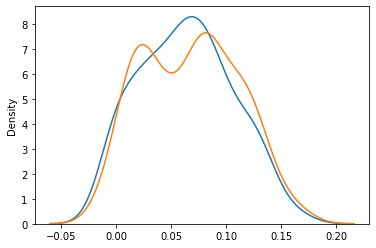

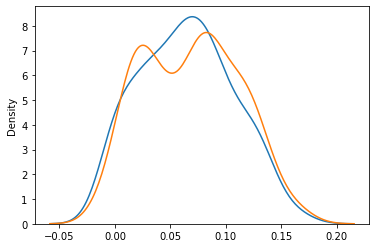

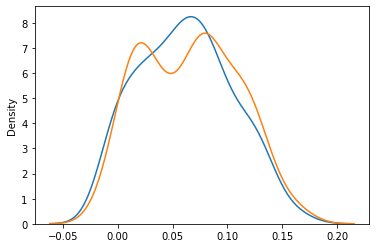

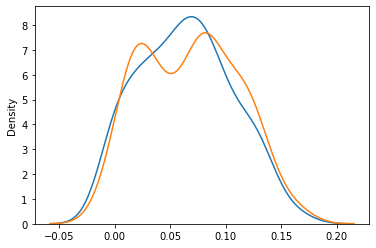

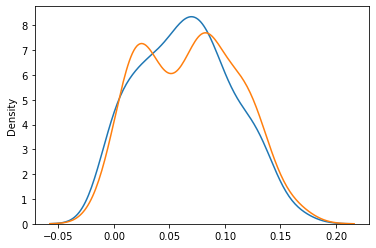

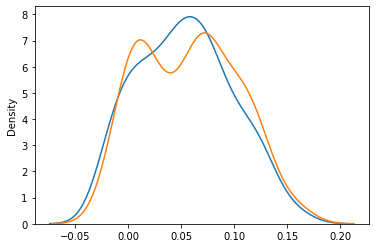

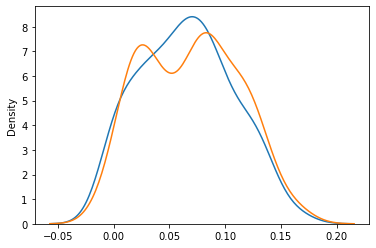

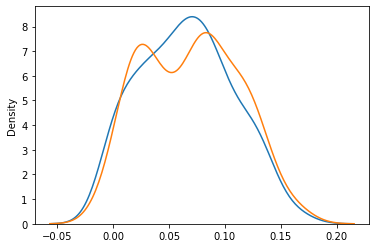

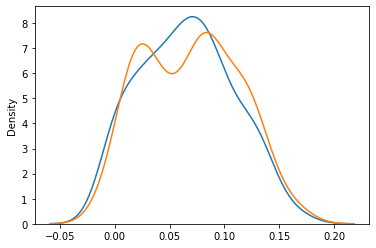

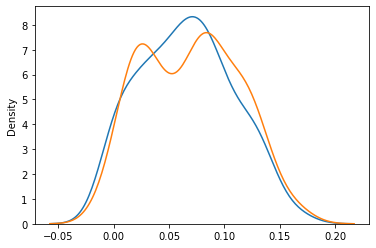

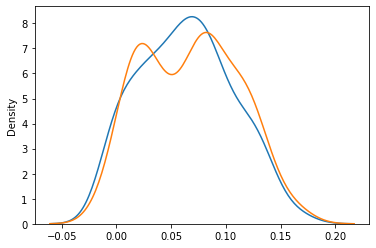

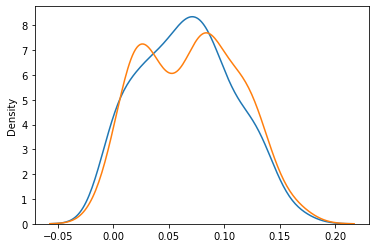

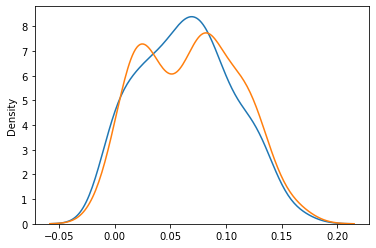

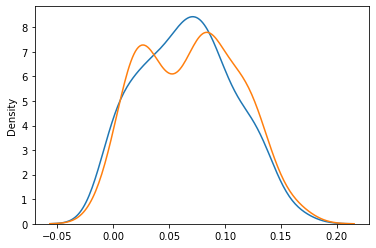

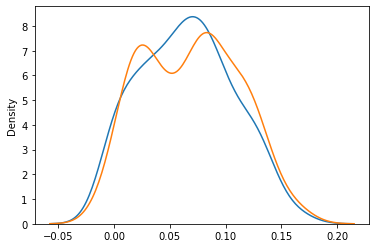

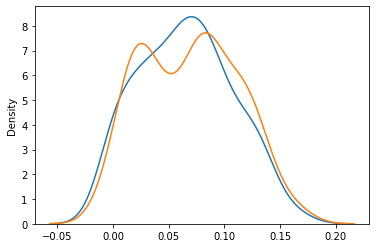

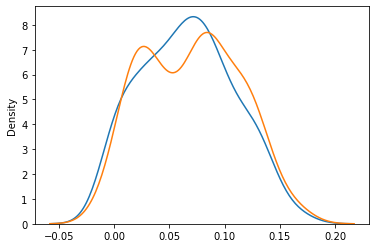

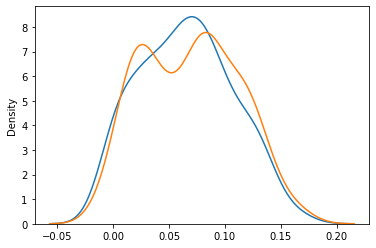

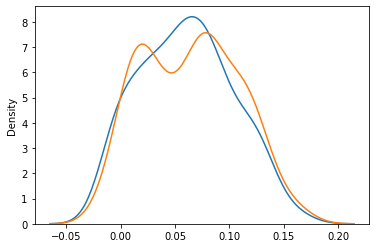

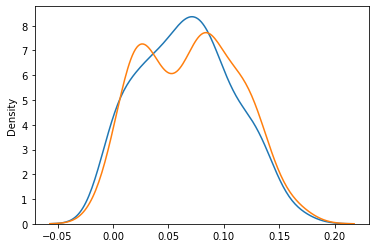

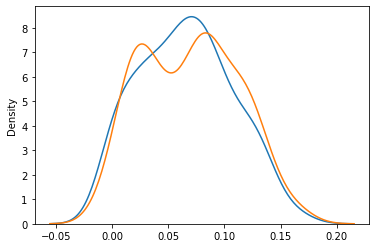

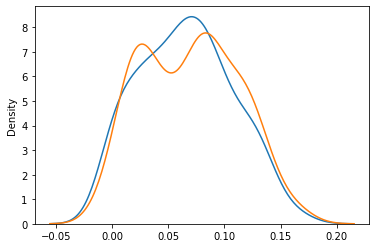

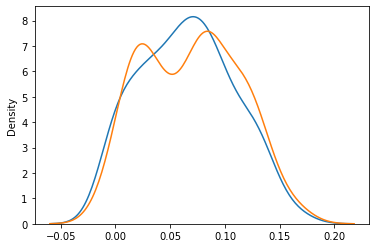

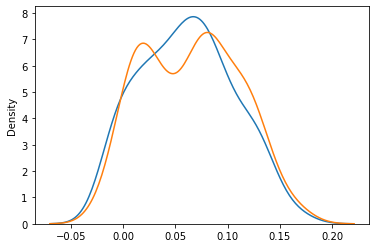

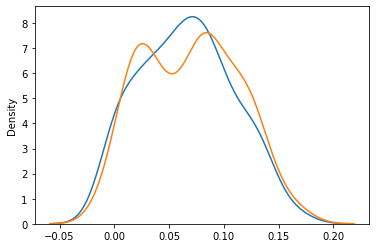

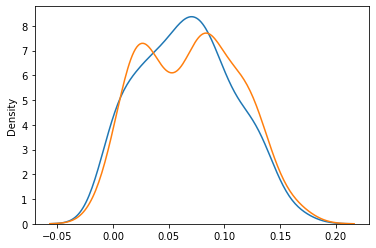

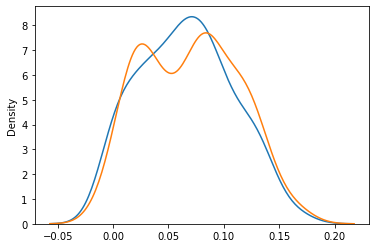

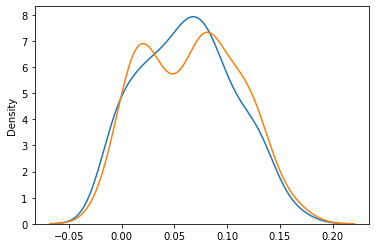

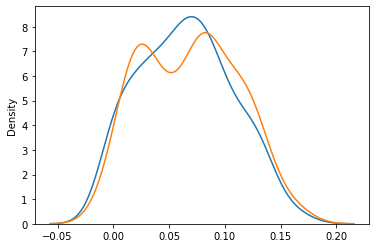

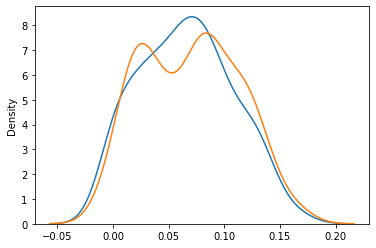

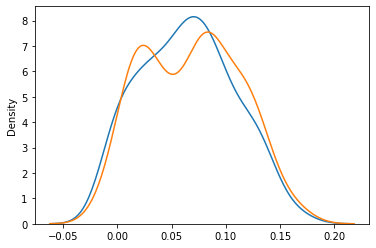

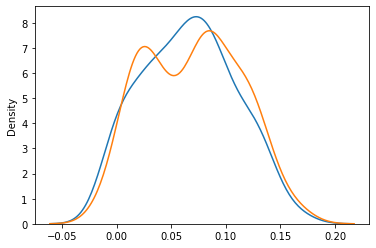

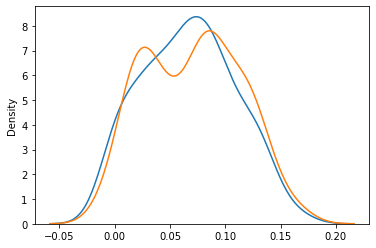

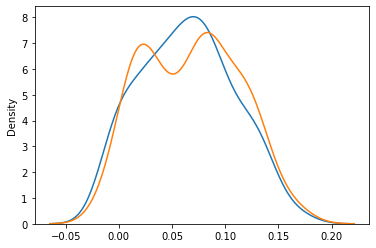

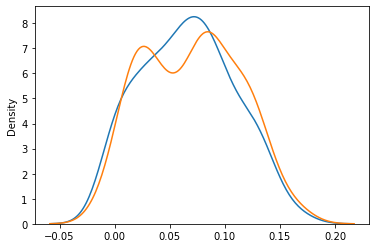

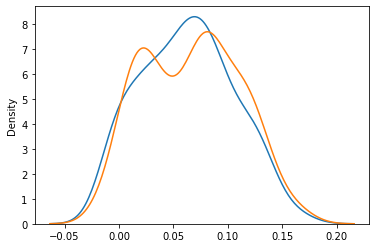

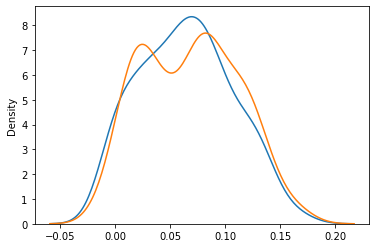

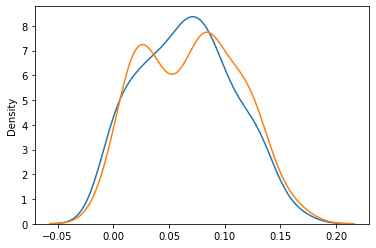

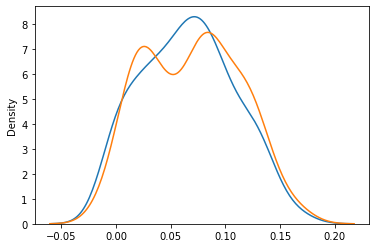

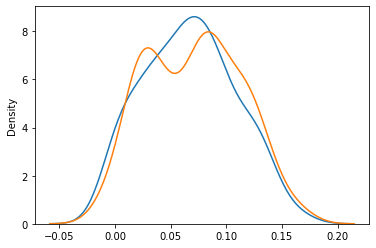

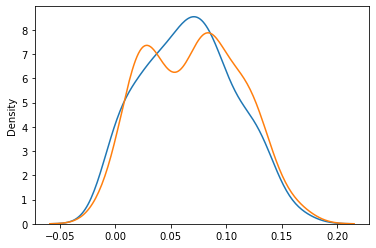

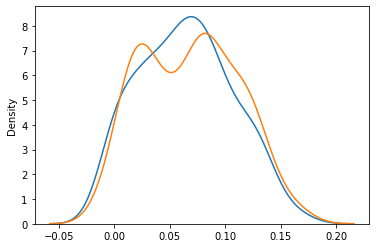

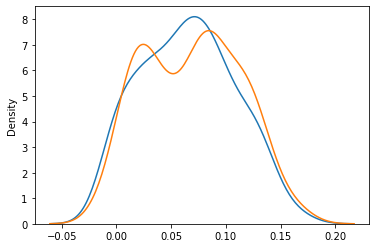

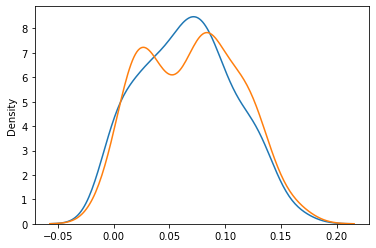

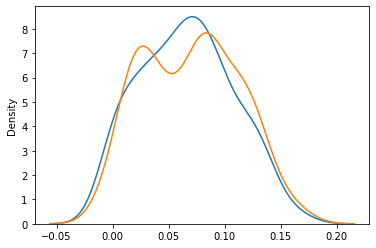

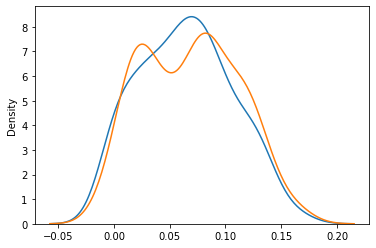

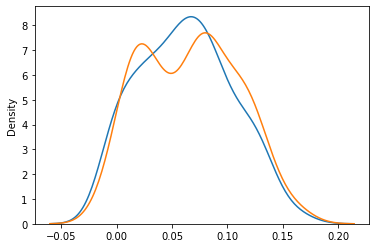

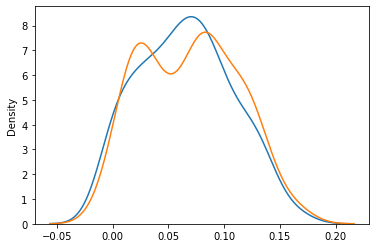

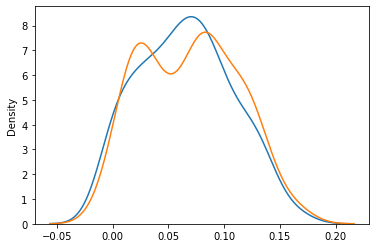

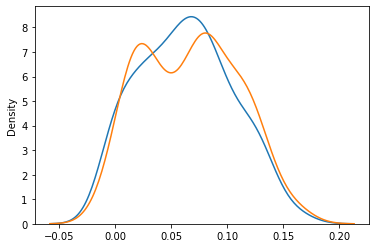

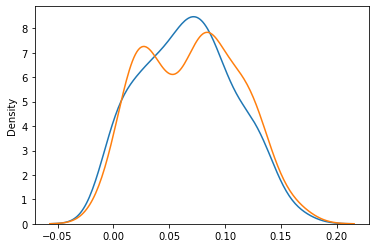

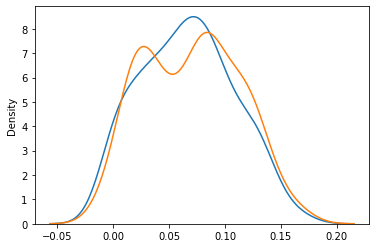

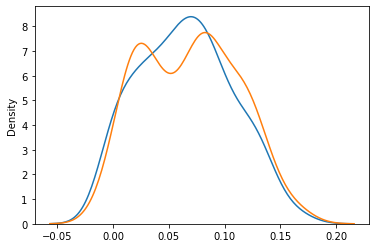

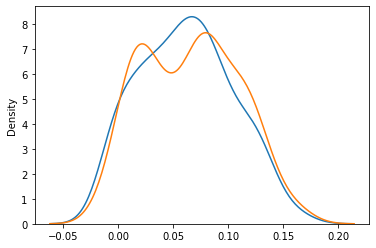

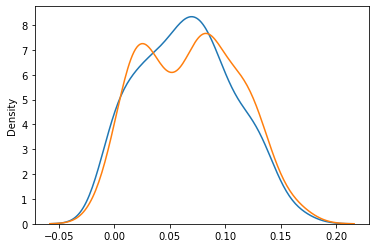

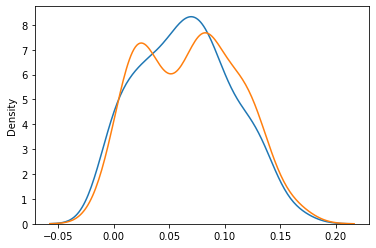

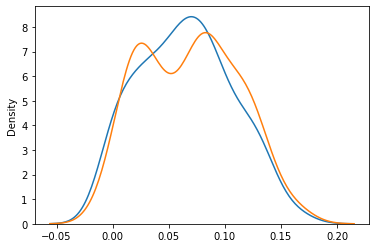

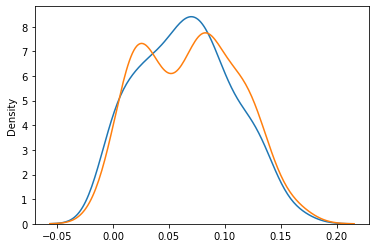

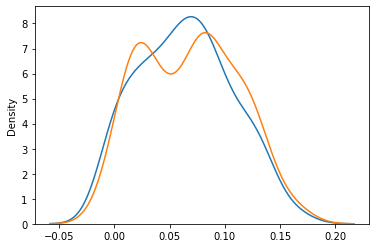

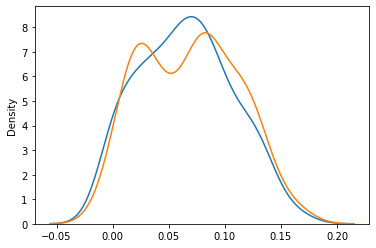

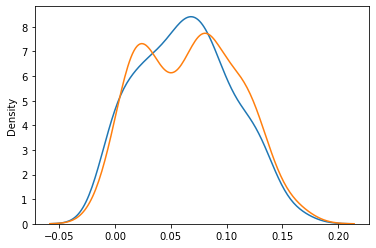

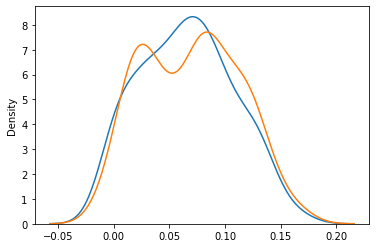

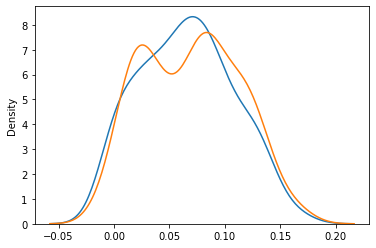

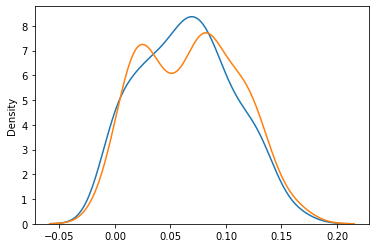

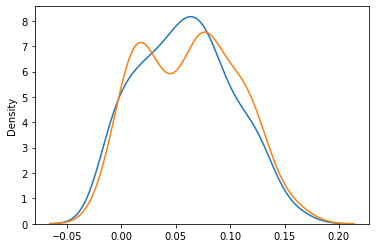

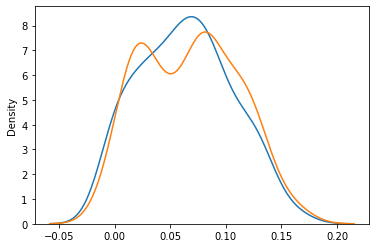

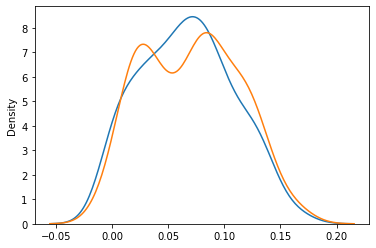

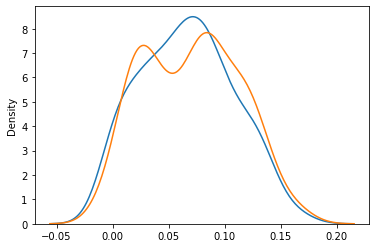

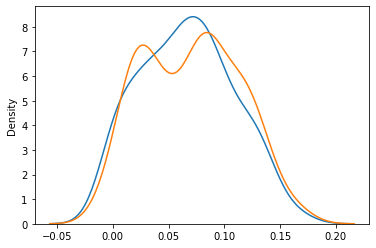

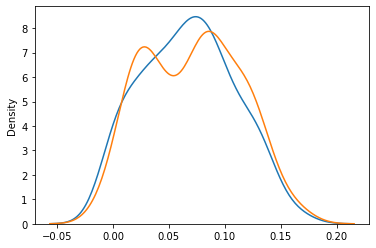

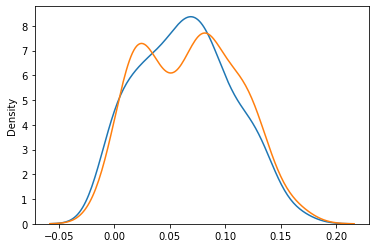

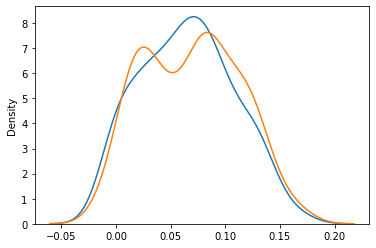

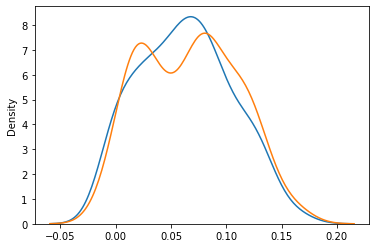

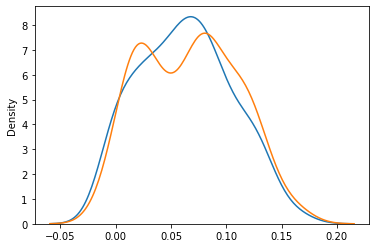

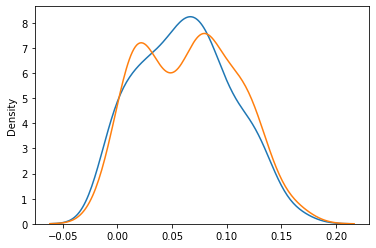

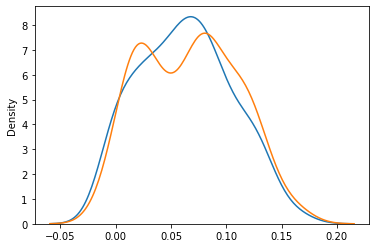

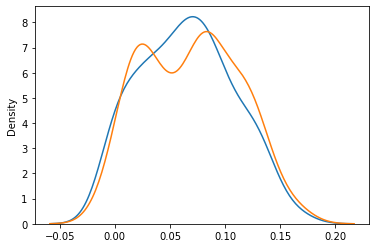

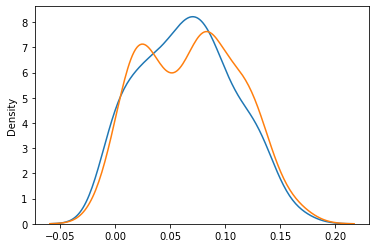

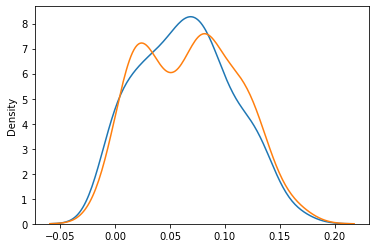

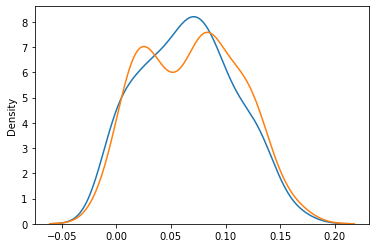

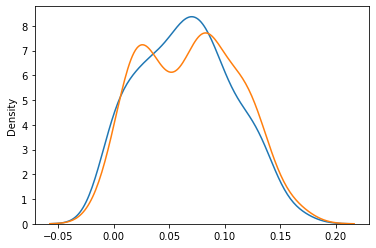

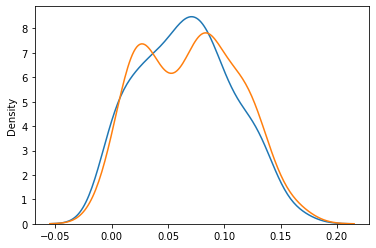

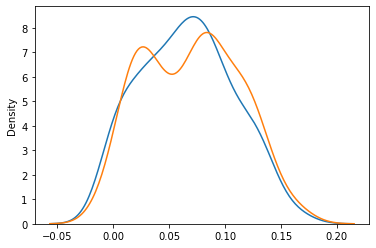

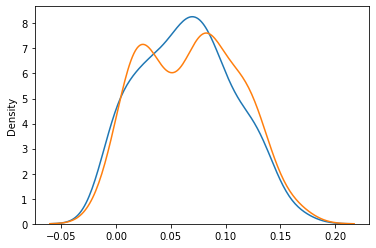

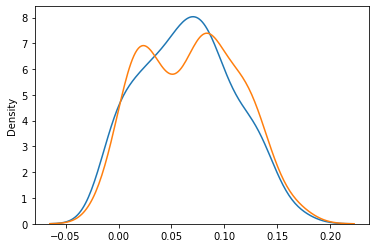

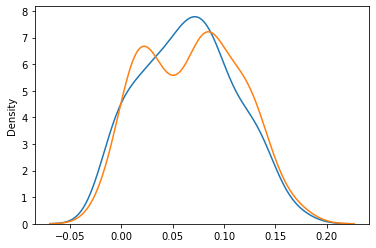

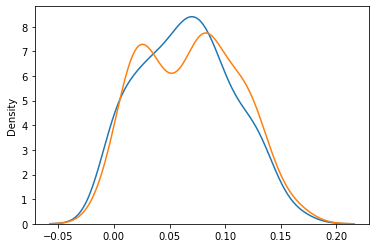

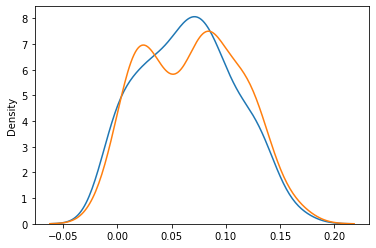

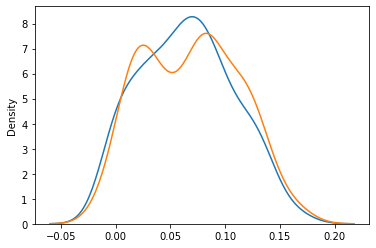

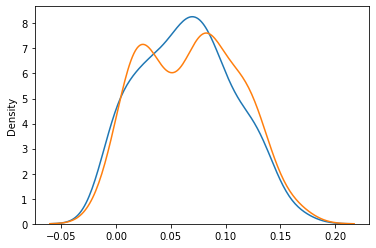

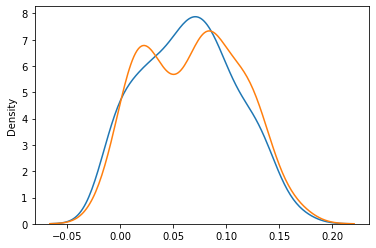

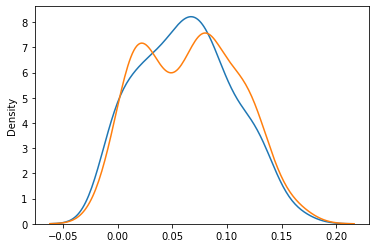

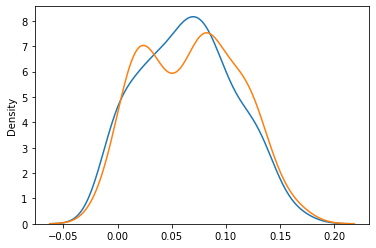

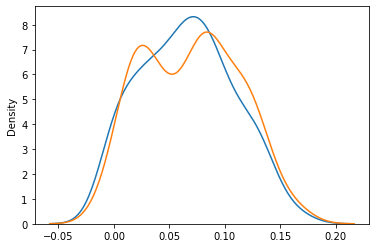

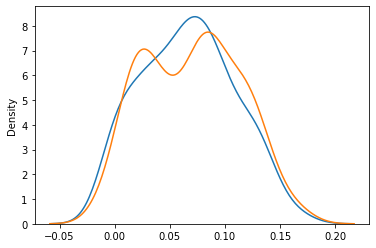

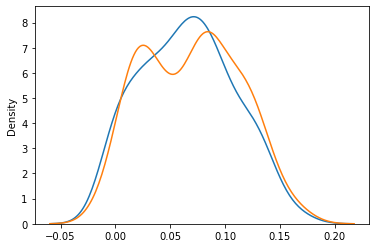

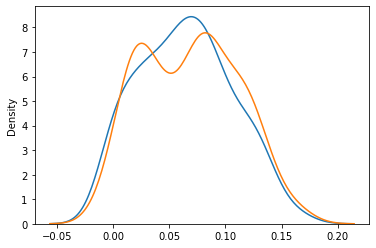

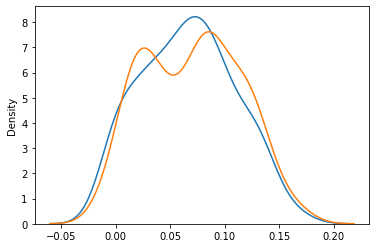

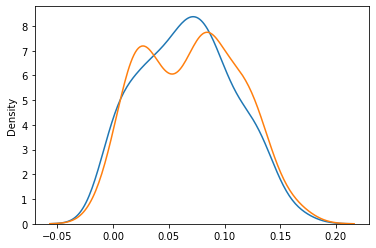

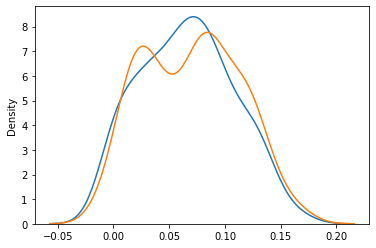

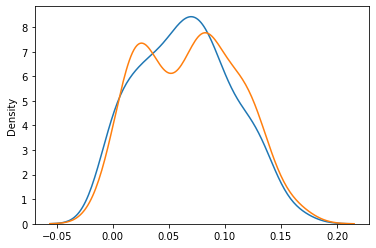

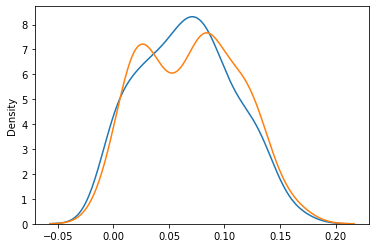

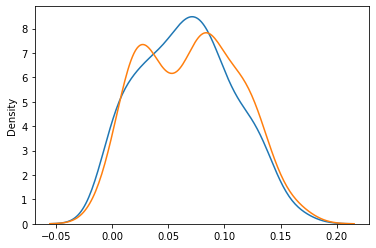

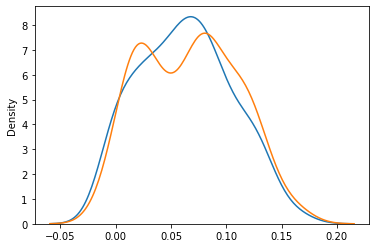

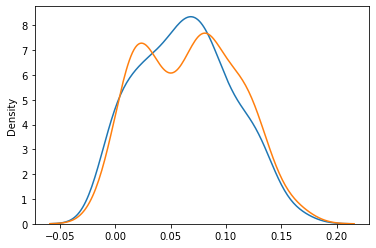

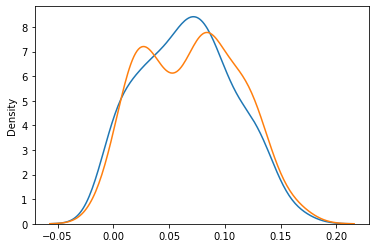

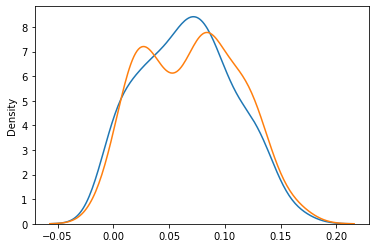

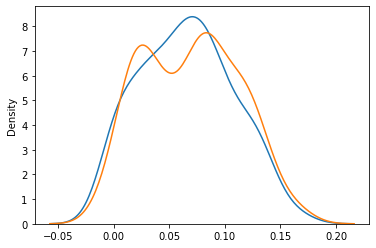

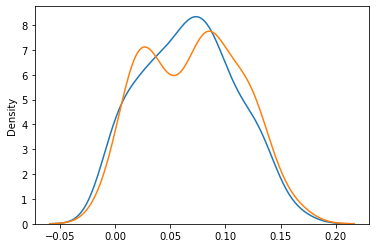

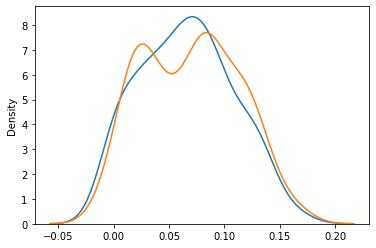

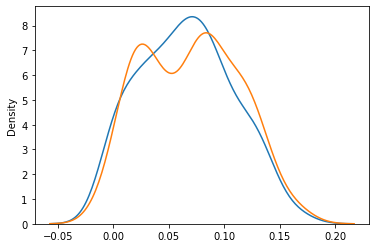

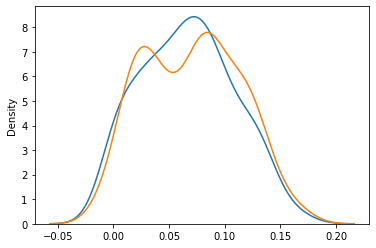

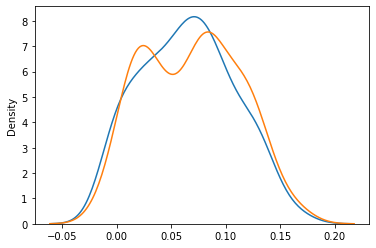

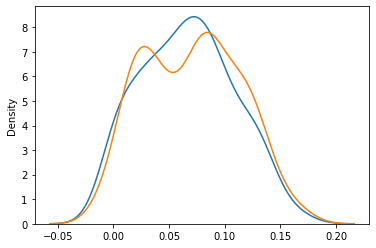

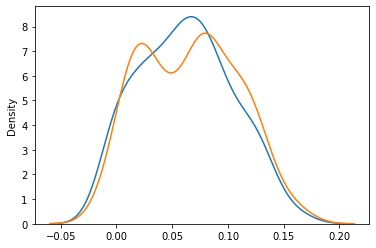

In [319]:
import seaborn as sns
import matplotlib.pyplot as plt
i = 8
for i in range(115):
    sns.kdeplot(out_train_1[:, i])
    sns.kdeplot(out_train_0[:, i])
    plt.show()

<AxesSubplot:ylabel='Density'>

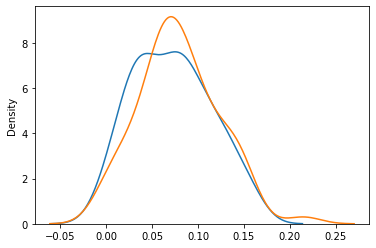

In [316]:
sns.kdeplot(out_test_1[:, i])
sns.kdeplot(out_test_0[:, i])

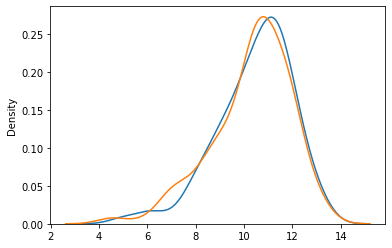

<AxesSubplot:ylabel='Density'>

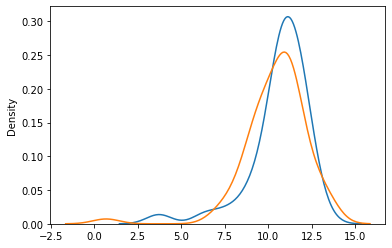

In [335]:
gene =43
dat = G.x[gene, :, 0].numpy()

out_train = dat[train_idx]
out_test = dat[test_idx]

idx = [True if i==1 else False for i in labels[train_idx]]
out_train_1 = out_train[idx]

idx = [True if i==0 else False for i in labels[train_idx]]
out_train_0 = out_train[idx]

idx = [True if i==1 else False for i in labels[test_idx]]
out_test_1 = out_test[idx]

idx = [True if i==0 else False for i in labels[test_idx]]
out_test_0 = out_test[idx]

sns.kdeplot(out_train_1)
sns.kdeplot(out_train_0)
plt.show()

sns.kdeplot(out_test_1)
sns.kdeplot(out_test_0)

In [344]:
from scipy import stats

stats.kstest(out_train_1, out_test_1)

KstestResult(statistic=0.1858695652173913, pvalue=0.03649378695793559)